In [1]:
#We are going to use a LSTM neural netowrk to perform a forecast into the Ethereum cryptocurrency with the data of the last 7 days

In [4]:
#Import of libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras
#Note the pip you have to run just once
#!pip install yfinance 
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [7]:
#Data from yfinance of ETHEREUM the last 7 days per minute
df = yf.download(tickers="ETC-EUR",period= '7d' ,interval='1m')
print(df.head())
Open = df['Open']

[*********************100%***********************]  1 of 1 completed
                                Open       High        Low      Close  \
Datetime                                                                
2022-04-15 00:00:00+00:00  34.260773  34.260773  34.260773  34.260773   
2022-04-15 00:01:00+00:00  34.264359  34.264359  34.264359  34.264359   
2022-04-15 00:02:00+00:00  34.251659  34.251659  34.251659  34.251659   
2022-04-15 00:03:00+00:00  34.257442  34.257442  34.257442  34.257442   
2022-04-15 00:04:00+00:00  34.285870  34.285870  34.285870  34.285870   

                           Adj Close  Volume  
Datetime                                      
2022-04-15 00:00:00+00:00  34.260773       0  
2022-04-15 00:01:00+00:00  34.264359  825056  
2022-04-15 00:02:00+00:00  34.251659       0  
2022-04-15 00:03:00+00:00  34.257442   15520  
2022-04-15 00:04:00+00:00  34.285870       0  


In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

Open = Open.to_numpy()
Open = Open[:,np.newaxis]
Open= scaler.fit_transform(Open)
Open
dataset = Open


In [9]:
#train/test
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print("Train:",len(train)," Test: ", len(test))

Train: 8460  Test:  940


In [10]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [17]:
# reshape into X=t and Y=t+1
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print("train shape is: ",train.shape)
print("test shape is: ",test.shape)

train shape is:  (8460, 1)
test shape is:  (940, 1)


In [18]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [19]:
# create and fit the LSTM neural network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1, batch_size=look_back, verbose=1)
print (model.summary())


422/422 [==============================] - 3s 2ms/step - loss: 0.0097
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4)                 400       
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 405
Trainable params: 405
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.09 RMSE
Test Score: 0.08 RMSE


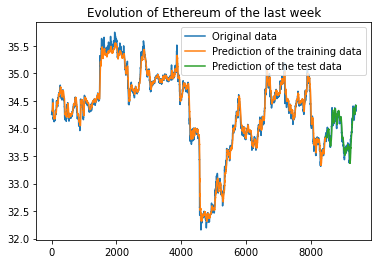

In [21]:
#showing the original dataset in blue,
#the predictions for the training dataset in green,
#and the predictions on the unseen test dataset in red.
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.title("Evolution of Ethereum of the last week")
plt.plot(scaler.inverse_transform(dataset),label="Original data")
plt.plot(trainPredictPlot,label="Prediction of the training data")
plt.plot(testPredictPlot,label="Prediction of the test data")
plt.legend()
plt.show()